/home/kianmilani/Projects/apra-howfsc-models/apra_pop_models
DEBUG:poppy:Skipping oversampling, oversample < 1 or already padded 


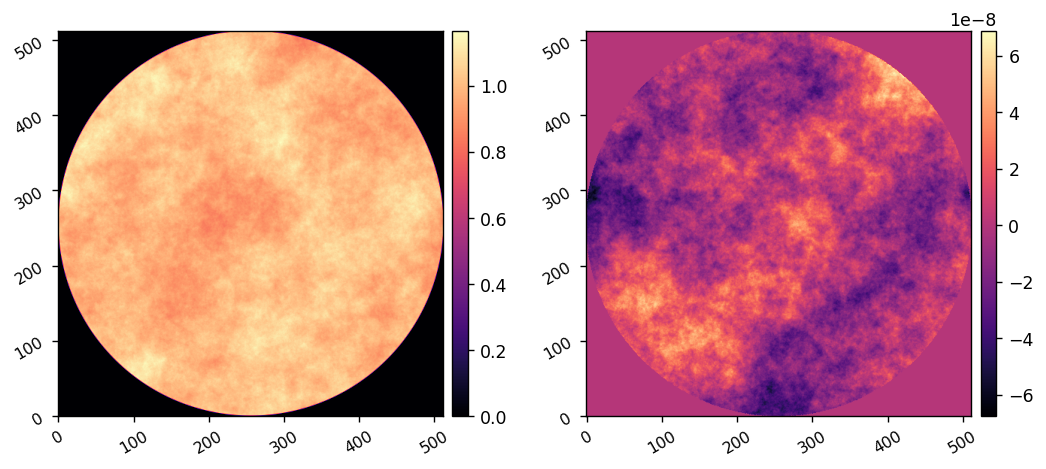

In [2]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fraunhofer_coro_2dm as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array
import apra_pop_models.utils as utils

from apra_pop_models.imshows import *

pupil_diam = 10.2*u.mm
wavelength_c = 650e-9*u.m

vortex = apra_pop_models.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)
focal_ratio = 350/500 # focal lengths of relay OAPs from DM pupil to 
lyot_diam = 0.85 * pupil_diam
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2) # adjust by the ratio of focal lengths

reload(utils)
wfe = utils.generate_wfe(diam=pupil_diam, npix=512, oversample=1,
                         opd_index=2.75, amp_index=2.75, 
                         opd_seed=123, amp_seed=1234,
                         opd_rms=20*u.nm, amp_rms=0.05, 
                         wavelength=wavelength_c)
CORO_WFE = poppy.ArrayOpticalElement(transmission=xp.abs(wfe),
                                     opd=xp.angle(wfe)*wavelength_c.to_value(u.m)/(2*np.pi), 
                                     pixelscale=pupil_diam/(512*u.pix),)
imshow2(CORO_WFE.amplitude, CORO_WFE.opd)

In [3]:
FN = 500
display(wavelength_c)
z = (pupil_diam**2/(wavelength_c*FN)).to(u.mm)
display(z)

<Quantity 6.5e-07 m>

<Quantity 320.12307692 mm>

In [7]:
400/500*9.5 * 0.85, 6.5/ (400/500*9.5)

(6.46, 0.8552631578947368)

In [35]:
reload(fraunhofer)
model = fraunhofer.CORO(npix=512, oversample=4,
                        use_lyot_stop=True,
                        )

model.um_per_lamD, model.psf_pixelscale_lamD


INFO:poppy:Loaded influence function from /home/kianmilani/Projects/apra-howfsc-models/apra_pop_models/inf.fits for DM
INFO:poppy:Loaded influence function from /home/kianmilani/Projects/apra-howfsc-models/apra_pop_models/inf.fits for DM


(<Quantity 20. um>, 0.25)

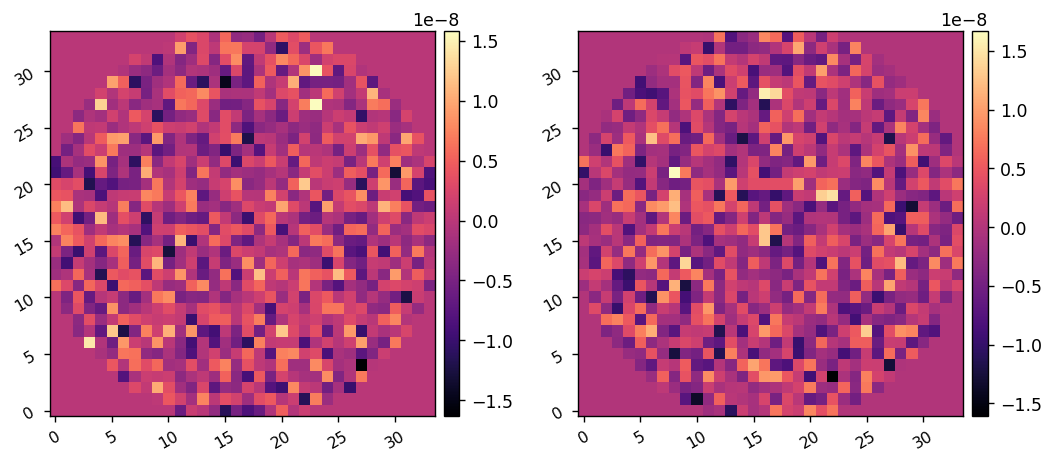

In [28]:
model.set_dm1(5e-9*np.random.randn(34**2).reshape(34,34)*model.dm_mask)
model.set_dm2(5e-9*np.random.randn(34**2).reshape(34,34)*model.dm_mask)
imshow2(model.get_dm1(), model.get_dm2())

DEBUG:poppy:Padded WF array for oversampling by 4.000, to (2048, 2048).
DEBUG:poppy:  Multiplied WF by phasor for Optic: Circle, radius=4.75 mm
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: DM


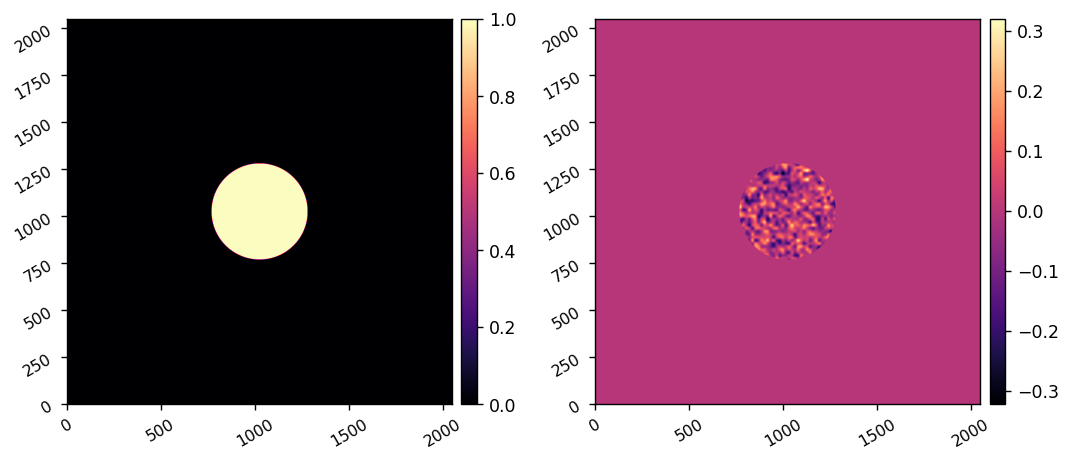

DEBUG:poppy:Beginning Fresnel Prop. Waist at z = 0.0 m
DEBUG:poppy:  Plane to Plane Regime, dz=320.0 mm
DEBUG:poppy:  Constant Pixelscale: 1.85546875e-05 m / pix
DEBUG:poppy:using cupy (GPU) FFT of (2048, 2048) array, FFT_direction=forward
DEBUG:poppy:    FFT_2D: FFT in 0.000329 s, full function  in 0.001 s
DEBUG:poppy:using cupy (GPU) FFT of (2048, 2048) array, FFT_direction=backward
DEBUG:poppy:    FFT_2D: FFT in 0.000236 s, full function  in 0.001 s
DEBUG:poppy:------ Propagated to plane of type PlaneType.intermediate at z = 3.20e-01 m ------
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: DM


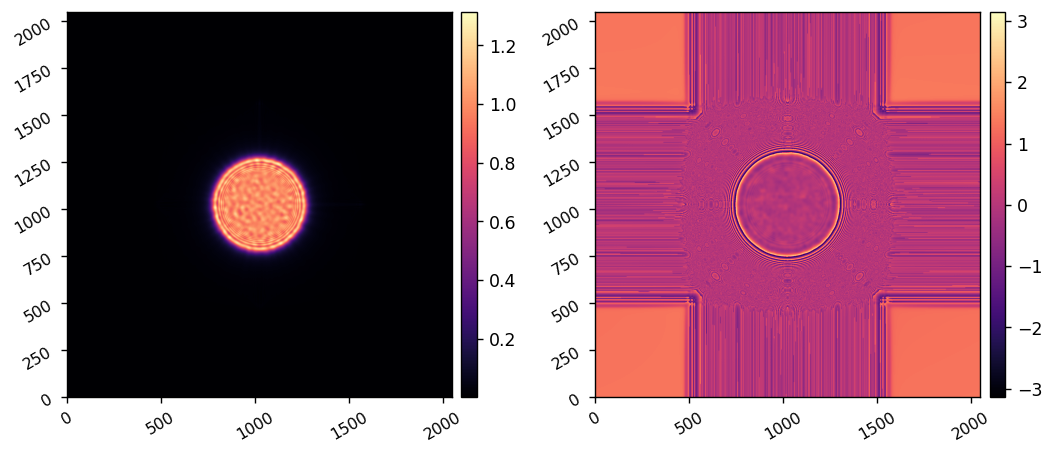

DEBUG:poppy:Beginning Fresnel Prop. Waist at z = 0.0 m
DEBUG:poppy:  Plane to Plane Regime, dz=-320.0 mm
DEBUG:poppy:  Constant Pixelscale: 1.85546875e-05 m / pix
DEBUG:poppy:using cupy (GPU) FFT of (2048, 2048) array, FFT_direction=forward
DEBUG:poppy:    FFT_2D: FFT in 0.000193 s, full function  in 0.001 s
DEBUG:poppy:using cupy (GPU) FFT of (2048, 2048) array, FFT_direction=backward
DEBUG:poppy:    FFT_2D: FFT in 0.000252 s, full function  in 0.001 s
DEBUG:poppy:------ Propagated to plane of type PlaneType.intermediate at z = 0.00e+00 m ------


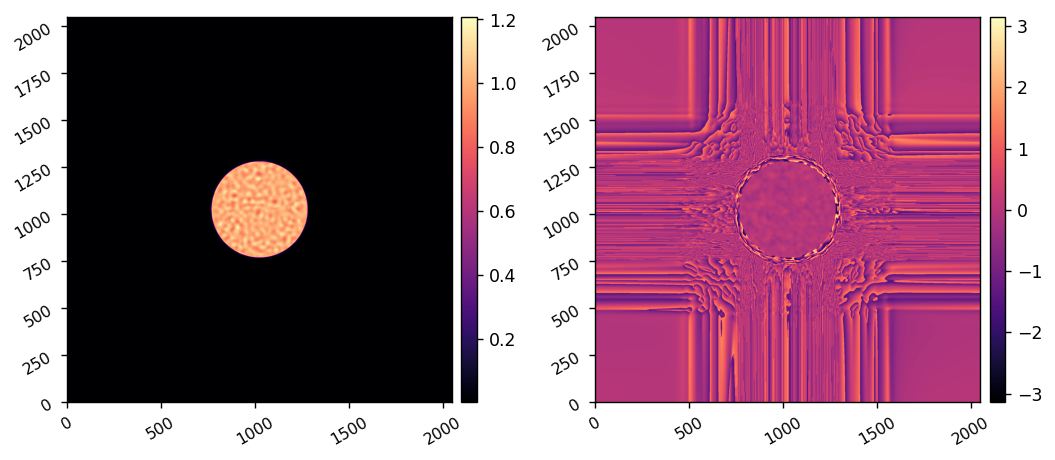

In [31]:
wf = poppy.FresnelWavefront(beam_radius=model.pupil_diam/2, wavelength=model.wavelength,
                                         npix=model.npix, oversample=model.oversample)
wf *= poppy.CircularAperture(radius=model.pupil_diam/2)
wf *= model.DM1
imshow2(wf.amplitude, wf.phase)
wf.propagate_fresnel(320*u.mm)
wf *= model.DM2
imshow2(wf.amplitude, wf.phase)

wf.propagate_fresnel(-320*u.mm)
imshow2(wf.amplitude, wf.phase)



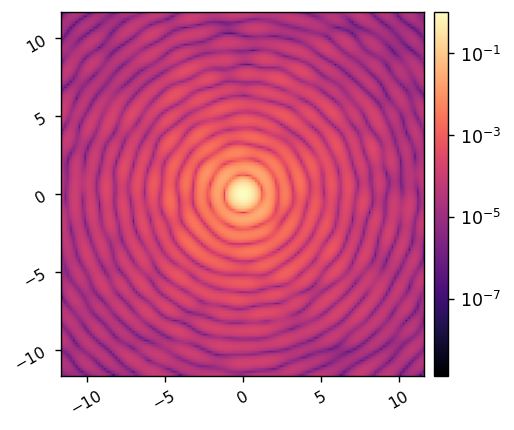

In [33]:
poppy_log.disabled = True

reload(fraunhofer)
model = fraunhofer.CORO()

model.pupil_diam = 9.5*u.mm

model.npix = 256
model.oversample = 4
model.npsf = 128

model.reset_dms()

model.RETRIEVED = None
model.RETRIEVED = CORO_WFE

model.Imax_ref = model.snap().max()
ref_im = model.snap()

imshow1(ref_im, lognorm=True, pxscl=model.psf_pixelscale_lamD)

In [94]:
reload(fraunhofer)
model = fraunhofer.CORO(npix=256, oversample=8,
                        pupil_diam=8*u.mm,
                        use_lyot_stop=True,
                        )

wfs = model.calc_wfs()

INFO:poppy:Loaded influence function from /home/kianmilani/Projects/apra-howfsc-models/apra_pop_models/inf.fits for DM1
INFO:poppy:Loaded influence function from /home/kianmilani/Projects/apra-howfsc-models/apra_pop_models/inf.fits for DM2
DEBUG:poppy:Padded WF array for oversampling by 8.000, to (2048, 2048).
DEBUG:poppy:  Multiplied WF by phasor for Optic: Circle, radius=4.0 mm


DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: DM1
DEBUG:poppy:Beginning Fresnel Prop. Waist at z = 0.0 m
DEBUG:poppy:  Plane to Plane Regime, dz=320.0 mm
DEBUG:poppy:  Constant Pixelscale: 3.125e-05 m / pix
DEBUG:poppy:using cupy (GPU) FFT of (2048, 2048) array, FFT_direction=forward
DEBUG:poppy:    FFT_2D: FFT in 0.000088 s, full function  in 0.000 s
DEBUG:poppy:using cupy (GPU) FFT of (2048, 2048) array, FFT_direction=backward
DEBUG:poppy:    FFT_2D: FFT in 0.000327 s, full function  in 0.001 s
DEBUG:poppy:------ Propagated to plane of type PlaneType.intermediate at z = 3.20e-01 m ------
DEBUG:poppy:  Multiplied WF by phasor for Pupil plane: DM2
DEBUG:poppy:Beginning Fresnel Prop. Waist at z = 0.0 m
DEBUG:poppy:  Plane to Plane Regime, dz=-320.0 mm
DEBUG:poppy:  Constant Pixelscale: 3.125e-05 m / pix
DEBUG:poppy:using cupy (GPU) FFT of (2048, 2048) array, FFT_direction=forward
DEBUG:poppy:    FFT_2D: FFT in 0.000082 s, full function  in 0.000 s
DEBUG:poppy:using cupy (GPU) F

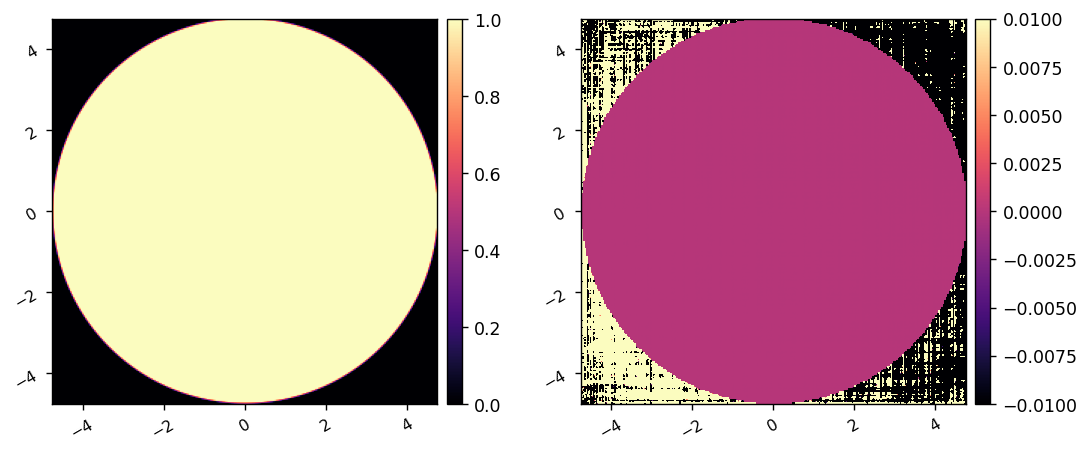

In [89]:
imshow2(wfs[5].amplitude, wfs[5].phase, npix=model.npix, pxscl=wfs[5].pixelscale.to(u.mm/u.pix), vmax2=0.01, vmin2=-0.01)

In [71]:
poppy.accel_math.fft_2d

<function poppy.accel_math.fft_2d(wavefront, forward=True, normalization=None, fftshift=True)>

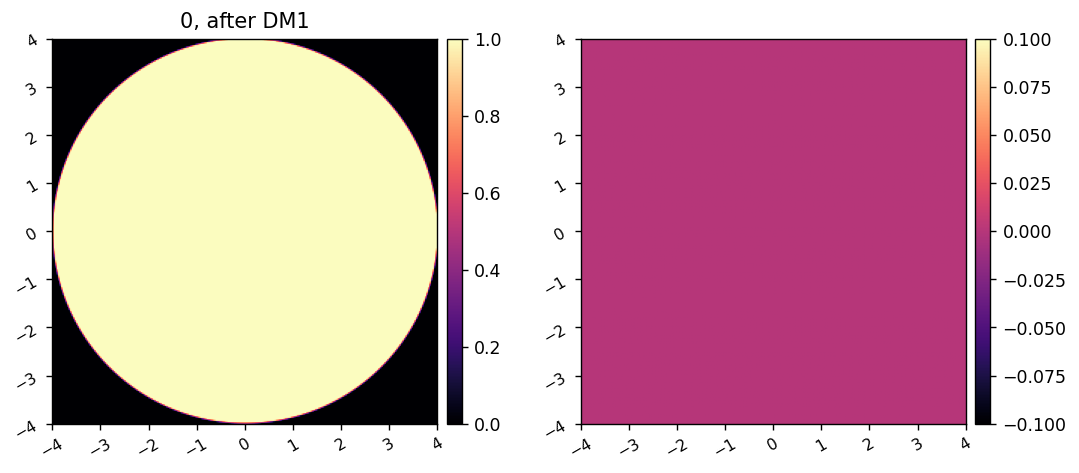

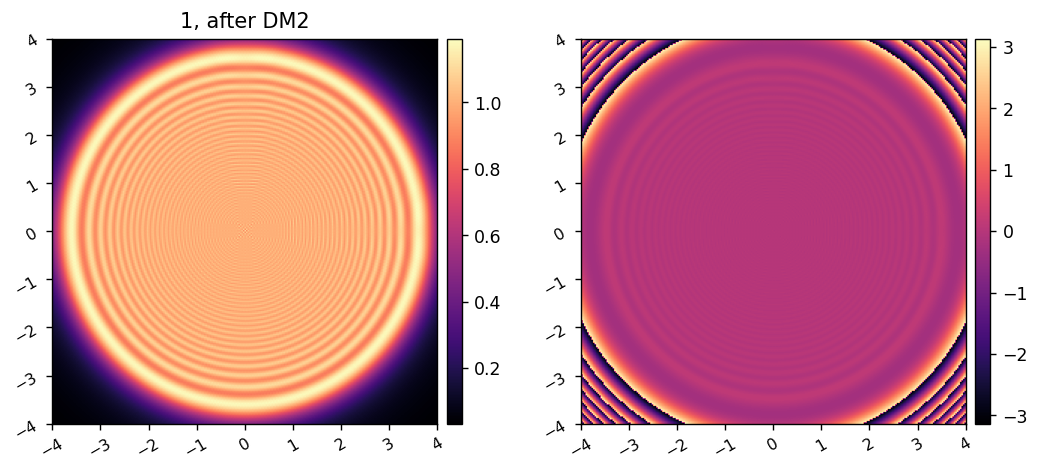

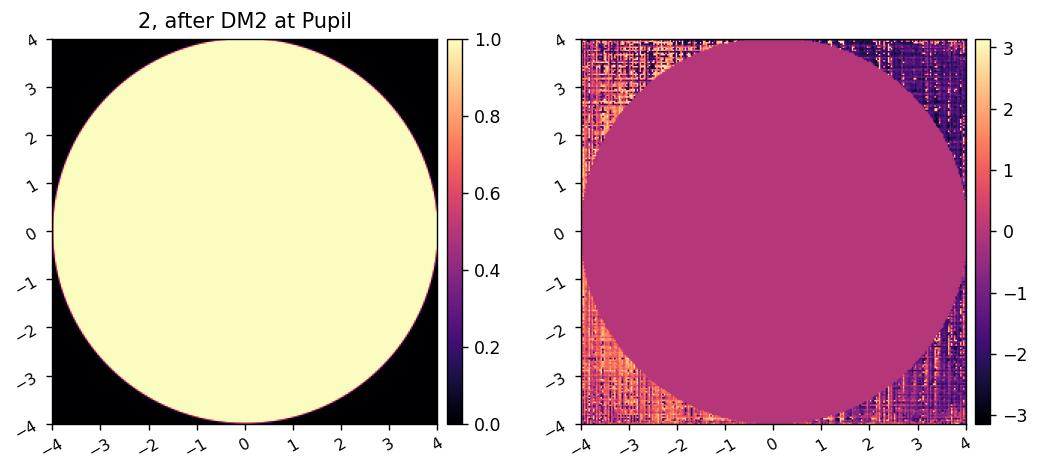

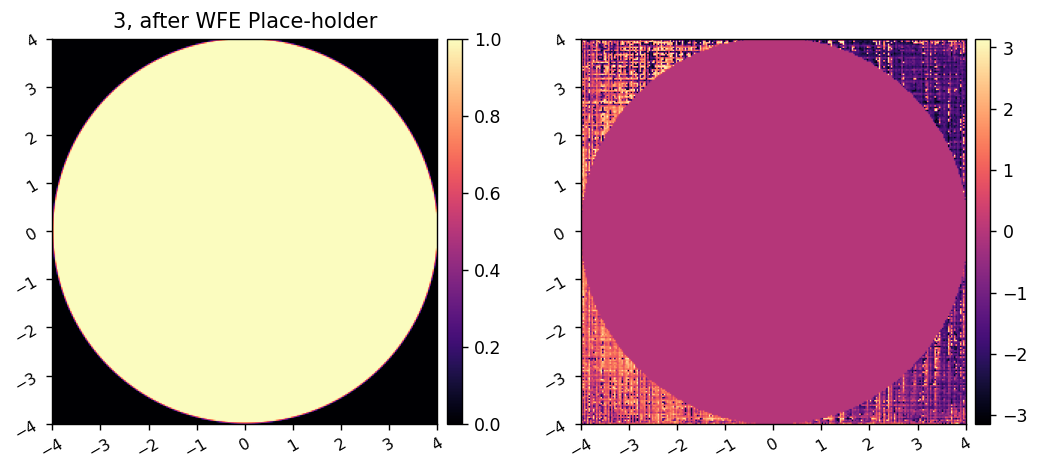

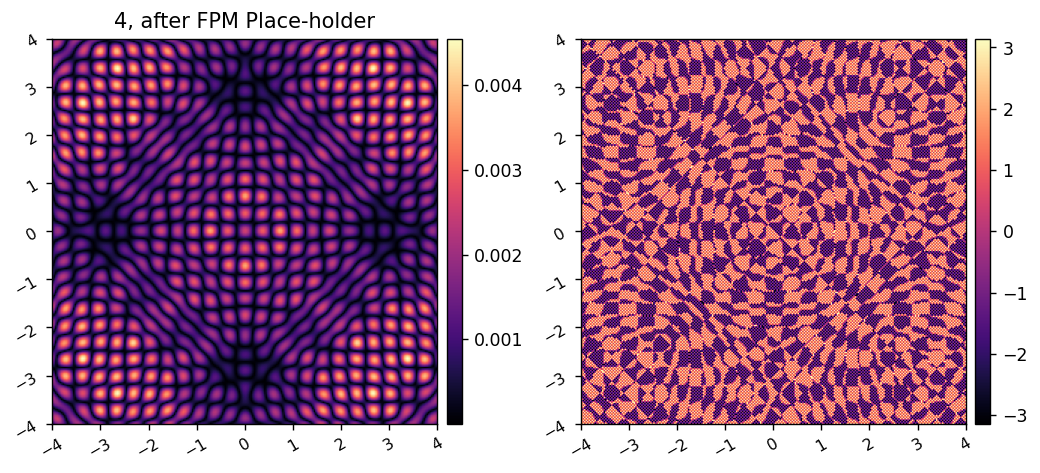

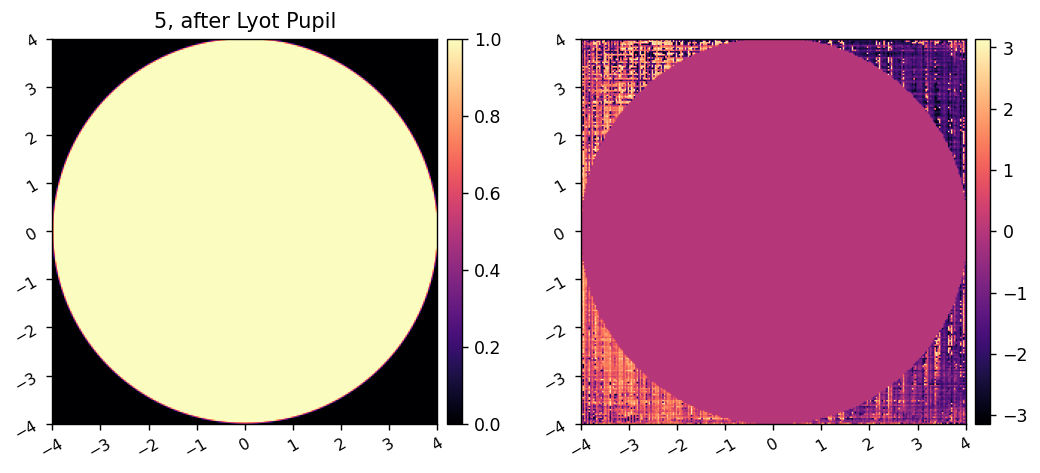

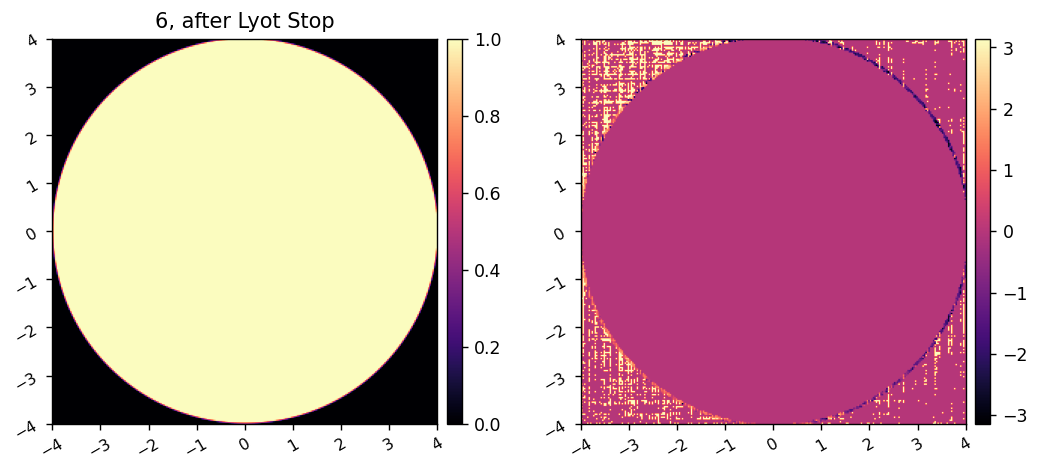

In [95]:
for i,wf in enumerate(wfs):
    if 'FPM' in wf.location:
        npix=256
    else:
        npix=model.npix
    imshow2(wf.amplitude, wf.phase, f'{i:d}, '+wf.location, npix=npix, pxscl=wf.pixelscale.to(u.mm/u.pix))

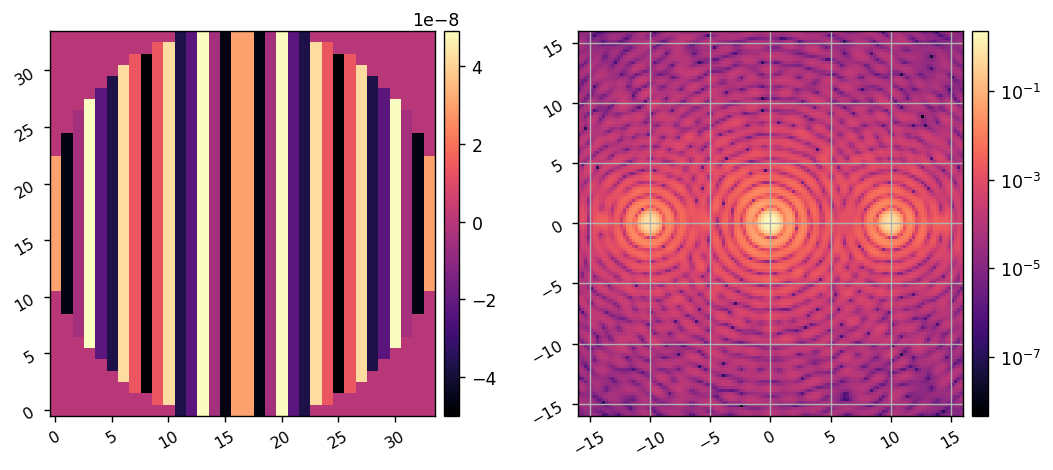

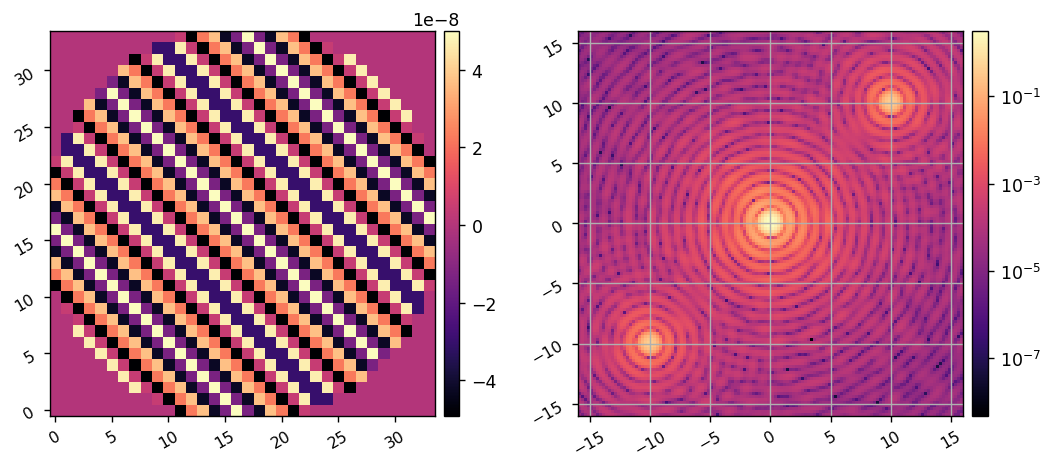

In [16]:
poppy_log.disabled = True

model.FPM = None
model.LYOT = None

Nact = model.Nact
xpp = np.arange(-model.Nact//2, model.Nact//2) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)

amp = 5e-8

separation = 10
com_1 = amp*np.cos(2*np.pi*ppx*separation/Nact)*model.dm_mask
com_2 = amp*np.cos(2*np.pi*(ppx + ppy)*separation/Nact)*model.dm_mask

model.set_dm(com_1)
im1 = model.snap()
imshow2(model.get_dm(), im1, pxscl2=model.psf_pixelscale_lamD, lognorm2=True, grid2=True)

model.set_dm(com_2)
im2 = model.snap()
imshow2(model.get_dm(), im2, pxscl2=model.psf_pixelscale_lamD, lognorm2=True, grid2=True)